In [1]:
import pandas as pd
import seaborn as sns
from statannotations.Annotator import Annotator
from be_predict_efficiency import predict as be_efficiency_model
import numpy as np 
import gpplot as gpp
from Bio import SeqIO
import matplotlib.pyplot as plt
import logomaker
from matplotlib.backends.backend_pdf import PdfPages

gpp.set_aesthetics()

Looking at active vs inactive guides in TP53 tiling and seeing if there how nucleotide identity around the editable base that impact activity



In [2]:
#Reading in all data that will be used

# Z-scores from activity-based selection TP53 screen etoposide arm
ABE= pd.read_excel("../../required_data/TP53/ABE_activity_zscores.xlsx",sheet_name="Sheet1")
CBE= pd.read_excel("../../required_data/TP53/CBE_activity_zscores.xlsx",sheet_name="Sheet1")

#subset to positive controls: guides that introduce missense, nonsense, or splice site mutations 
poscon_mutations=["Missense","Nonsense","Splice site"]

ABE=ABE[ABE["Mutation bin"].isin(poscon_mutations)].reset_index(drop=True)
CBE=CBE[CBE["Mutation bin"].isin(poscon_mutations)].reset_index(drop=True)

#further subset to positive controls: remove guides that introduce benign mutations
#this reduces the chance that guides are falsely called inactive due to lack of depletion
ABE_benign_guides=pd.read_csv("../../required_data/TP53/ABE_benign_TP53_etoposide_activitybased_zscores.csv")["sgRNA Target Sequence"].tolist()
ABE=ABE[ABE["sgRNA Target Sequence"].isin(ABE_benign_guides)==False].reset_index(drop=True)
CBE_benign_guides=pd.read_csv("../../required_data/TP53/CBE_benign_TP53_etoposide_activitybased_zscores.csv")["sgRNA Target Sequence"].tolist()
CBE=CBE[CBE["sgRNA Target Sequence"].isin(CBE_benign_guides)==False].reset_index(drop=True)

#retrieve guide-level beagle output to obtain the context sequences associated with each guide
guide_level_output=pd.read_table("../../required_data/TP53/tp53_ABE_3_9-guides.txt",usecols=['sgRNA Sequence', 'sgRNA Context Sequence','PAM Sequence', 'sgRNA Sequence Start Pos. (global)','sgRNA Orientation'])


### Logo Plots

In [3]:
def get_nt_frequencies(df,editable_nt):
    '''
    Searches for editable nucleotides in the 4-8 window and indicates the nucleotide identity at all relative positions
    For guides with multiple editable nucleotides in the editing window, reports each as a separate data point
    Serves as input for logomaker.logo()

    inputs:
        df: dataframe with guide sequences. ideally already subset for a certain z-score for logo plot to be meaningful
        editable_nt: "A" for ABE or "C" for CBE
    outputs:
        returns a dataframe where each row is a position relative to the editable nt, column is A,C,G,T, value is
        proportion of guides in df with that nucleotide at that position 
    '''
    df_logoplots=df.copy()
    df_logoplots["4-8 window"]=df_logoplots["sgRNA Target Sequence"].str[3:8]
    df_logoplots["editable_index"]=df_logoplots["4-8 window"].apply(lambda x: [i[0]+3 for i in enumerate(x) if i[1]==editable_nt])
    df_logoplots=df_logoplots.explode("editable_index")
    df_logoplots["-3 to editable nt"]=df_logoplots.apply(lambda x: x["sgRNA Target Sequence"][x["editable_index"]-3],axis=1)
    df_logoplots["-2 to editable nt"]=df_logoplots.apply(lambda x: x["sgRNA Target Sequence"][x["editable_index"]-2],axis=1)
    df_logoplots["-1 to editable nt"]=df_logoplots.apply(lambda x: x["sgRNA Target Sequence"][x["editable_index"]-1],axis=1)
    df_logoplots["+1 to editable nt"]=df_logoplots.apply(lambda x: x["sgRNA Target Sequence"][x["editable_index"]+1],axis=1)
    df_logoplots["+2 to editable nt"]=df_logoplots.apply(lambda x: x["sgRNA Target Sequence"][x["editable_index"]+2],axis=1)
    df_logoplots["+3 to editable nt"]=df_logoplots.apply(lambda x: x["sgRNA Target Sequence"][x["editable_index"]+3],axis=1)
    df_logoplots=df_logoplots.iloc[:,-6:]
    df_length=len(df_logoplots)
    nt_frequencies=pd.concat(
        [pd.DataFrame(df_logoplots["-3 to editable nt"].value_counts()/df_length).T,
         pd.DataFrame(df_logoplots["-2 to editable nt"].value_counts()/df_length).T,
         pd.DataFrame(df_logoplots["-1 to editable nt"].value_counts()/df_length).T,
         pd.DataFrame({"G":[0],"C":[0],"T":[0],"A":[0],editable_nt:[1]}),
         pd.DataFrame(df_logoplots["+1 to editable nt"].value_counts()/df_length).T,
         pd.DataFrame(df_logoplots["+2 to editable nt"].value_counts()/df_length).T,
         pd.DataFrame(df_logoplots["+3 to editable nt"].value_counts()/df_length).T])
    nt_frequencies.index=[-3,-2,-1,0,1,2,3]
    return nt_frequencies


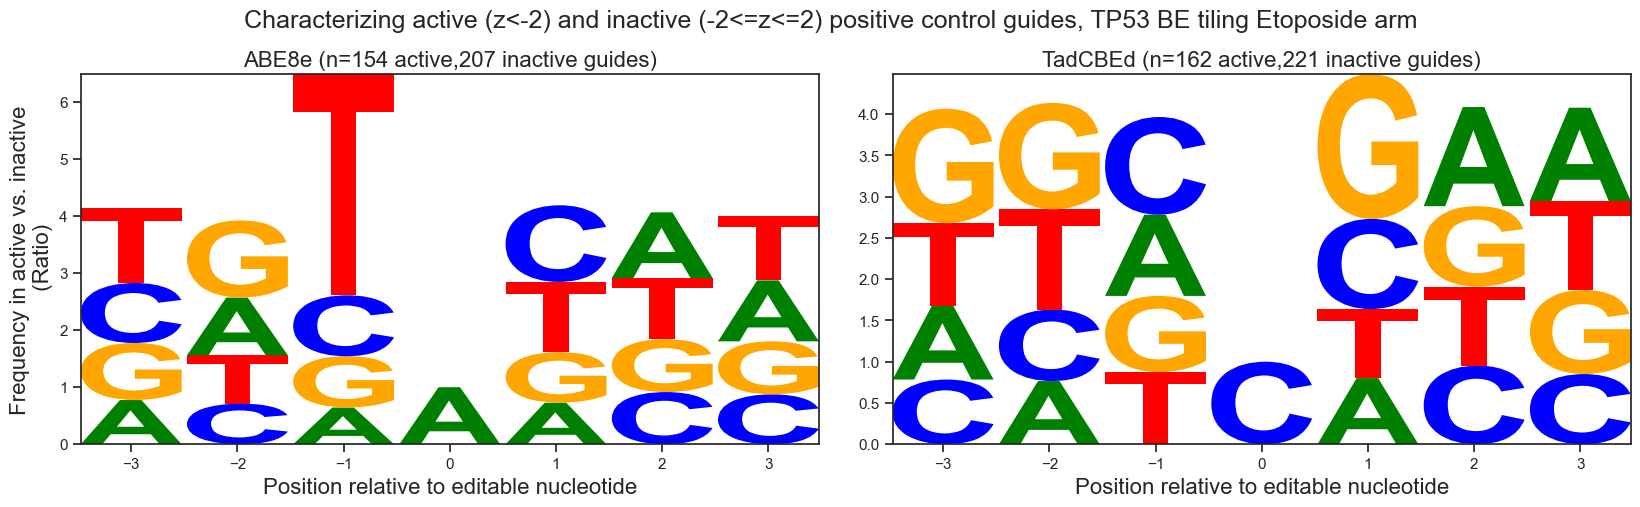

In [6]:
(fig,ax)= plt.subplots(1,2,figsize=(20,5))
fig.subplots_adjust(wspace=0.1,top=0.85)

fig.suptitle("Characterizing active (z<-2) and inactive (-2<=z<=2) positive control guides, TP53 BE tiling Etoposide arm",fontsize=18)

active_ABEs= ABE[ABE["Eto_RepAB_D21;z-score"]<-2]
inactive_ABEs=ABE[(ABE["Eto_RepAB_D21;z-score"]<=2)&(ABE["Eto_RepAB_D21;z-score"]>=-2)]
logomaker.Logo((get_nt_frequencies(active_ABEs,"A")/get_nt_frequencies(inactive_ABEs,"A")).fillna(0),ax=ax[0])
ax[0].set_ylabel("Frequency in active vs. inactive\n (Ratio)",fontsize=16)
ax[0].set_xlabel("Position relative to editable nucleotide",fontsize=16)
ax[0].set_title("ABE8e (n="+str(len(active_ABEs))+" active,"+str(len(inactive_ABEs))+" inactive guides)",fontsize=16)


active_CBEs= CBE[CBE["Eto_RepAB_D21;z-score"]<-2]
inactive_CBEs=CBE[(CBE["Eto_RepAB_D21;z-score"]<=2)&(CBE["Eto_RepAB_D21;z-score"]>=-2)]
logomaker.Logo((get_nt_frequencies(active_CBEs,"C")/get_nt_frequencies(inactive_CBEs,"C")).fillna(0),ax=ax[1])
ax[1].set_xlabel("Position relative to editable nucleotide",fontsize=16)
ax[1].set_title("TadCBEd (n="+str(len(active_CBEs))+" active,"+str(len(inactive_CBEs))+" inactive guides)",fontsize=16)

#gpp.savefig("nt_identity_logo_plots_ABE8e_TadCBEd_positivecontrols.pdf",bbox_inches="tight",dpi=600)